# COVID Hospital mapping for Spain
This notebook recreates the analysis performed by Bruno Sanchez for Spain. 
It is prototyping code, so don't expect too much.

## Download the OSM data for Ethiopa

In [ ]:
!fish
!set BBOX "39.1316150933459284, 8.2278188964048251, 39.9188985300577457, 8.7135061906947033
wget -P data/ -O eth-AOI-1.osm "http://overpass.openstreetmap.ru/cgi/xapi_meta?*[bbox=$BBOX]"
osmconvert -v eth-AOI-1.osm -o=eth-AOI-1.o5m


Welcome to fish, the friendly interactive shell⏎                                                                               
Type `help` for instructions on how to use fish
Philippe@192 ~/P/covid19 (master)> [m

## Start the OSM routing engine

In [ ]:
# for some reason, I had to use OSRM-contract instead of the usual routine. Also, we use algorithm "ch"
!docker run -t -v "$PWD:/data" osrm/osrm-backend osrm-extract -p /opt/car.lua /data/asturias.osm
!docker run -t -v "$PWD:/data" osrm/osrm-backend osrm-contract /data/eth-AOI-1.osrm
!docker run -t -i -p 5000:5000 -v $PWD:/data osrm/osrm-backend osrm-routed --algorithm ch /data/asturias.osrm


## Read the settlement data

In [6]:
map_file = "./QGIS files/Ethiopia_AOI1/layers/AOI-1_population_eth_2018-10-01.tif"
# TODO There is probably a better way
# data_folder=Path('.')/'data'/location

In [30]:
import numpy as np
import rasterio
import pandas as pd
from rasterio.windows import Window
from matplotlib import pyplot

def get_pop(map_file,left_x,top_y,window,plot=False):
    """
    get_pop(raster filename,left_x,top_y,window,plot=False)
    
    Given a raster file, and row,cols ranges,
    return the lonlat of the ranges, nancount, and the nunsum
    
    Optionally plot the raster window [False]
    """
    right_x,bottom_y = left_x + window, top_y + window
    with rasterio.open(map_file) as src:
        left_lon, top_lat = src.xy(top_y,left_x)
        right_lon, bottom_lat = src.xy(bottom_y, right_x )
        center_lon , center_lat = (right_lon + left_lon)/2., (top_lat+bottom_lat)/2.
                             #Window(col_off, row_off, width, height)
        w = src.read(1, window=Window(left_x, top_y, window, window))
        if plot:
            pyplot.imshow(w, cmap='pink')
            pyplot.show()
        nancount=np.count_nonzero(~np.isnan(w))
        count = np.size(w)
        tot_pop=np.nansum(w)
    if count == 0:
        return {} #Out of bounds
    if tot_pop == 0 or window < 1: #Mark the window no further split.
        split=False
    else:
        split=True
    out={'window':window,
         'left_x':left_x,
         'right_x':right_x,
         'top_y':top_y,
         'bottom_y':bottom_y,
         'left_lon':left_lon, 
         'top_lat':top_lat, 
         'right_lon':right_lon,
         'bottom_lat':bottom_lat,
         'center_lon':center_lon , 
         'center_lat':center_lat,
         'count': count,
         'nancount':nancount,
         'tot_pop':tot_pop,
         'split': split}
    return out

In [32]:
# TODO : Does it matter if the origins have different sizes? NO, I don't think so actually.
#Scan the raster map with big windows
origins=pd.DataFrame()
window=2000
with rasterio.open(map_file) as src:
    a=src.xy(0,1)
    for left_x in np.arange(0,src.width,window):
        for top_y in np.arange(0,src.height,window):
            out=get_pop(map_file,left_x,top_y,window,plot=False)
            if out != {}:
                origins=origins.append([out])
        print("%i/%i\r"%(left_x,src.width),end="")


In [33]:
def split(map_file,origin,plot=False):
    """
    Split a window row in 4 parts, and return new rows results
    """
    origins=pd.DataFrame()
    window=int(origin.window/2)
    for left_x in np.arange(origin.left_x,origin.right_x,window):
        for top_y in np.arange(origin.top_y,origin.bottom_y,window):
            out=get_pop(map_file,left_x,top_y,window,plot=plot)
            if out != {}:
                origins=origins.append([out])
    return origins

In [38]:
#Do a splitting pass
#run this cell as many times as you want to split the windows
print("%i regions need splitting"%len(origins[origins['split']==True]))
olen=len(origins)
for i in np.arange(olen):
    print("%i/%i\r"%(i+1,olen),end="")
    if origins.iloc[i,origins.columns.get_loc('split')] == True:
        origins.iloc[i,origins.columns.get_loc('split')]='done'
        s=split(map_file,origins.iloc[i])
        origins=origins.append(s,sort=False)
print("done.")
print("We now have %i regions, %i will be split in next round"%(len(origins),len(origins[origins['split']==True])))


321 regions need splitting
done.38
We now have 3220 regions, 2643 will be split in next round


In [41]:
# only keep the origins which have more than one person living and only
# the throw out the entries which have been split (otherwise we have copies)
origins=origins[origins['tot_pop']>0]
origins=origins[origins['split']!='done']
print("We have %i regions of size %i, %i with population >0"%
      (len(origins),min(origins['window']),len(origins[origins['tot_pop']>0])))

We have 2643 regions of size 62, 2643 with population >0


In [42]:
#make it geopandas settin a bounding box TODO: EPSG:4327 is deprecated, I think
# we should use EPSG:4326
import geopandas as gdp
from shapely.geometry import Point
from shapely.geometry import box
origins=gdp.GeoDataFrame(origins,crs='epsg:4327', geometry=[Point(xy) for xy in zip(origins['center_lon'], origins['center_lat'])])
origins.geometry=origins.apply(lambda r: box(r.left_lon, r.bottom_lat, r.right_lon, r.top_lat, ccw=False),axis=1)

In [47]:
origins.to_file(driver = 'ESRI Shapefile', filename = 'test_origins.shp')

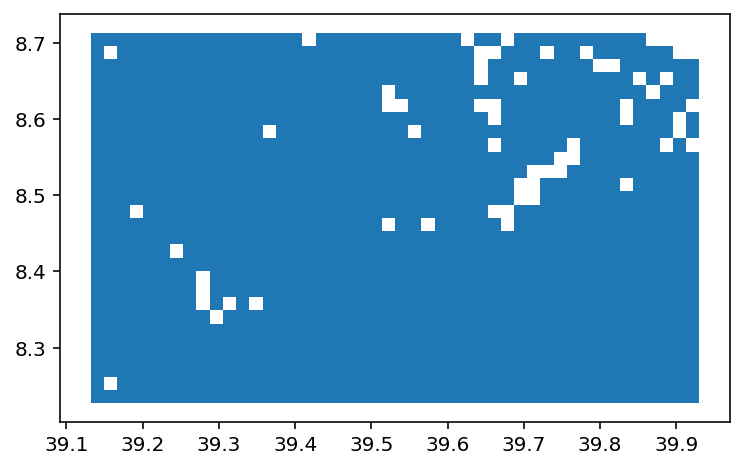

In [44]:
origins.plot()

## import hospitals

In [60]:
import geopandas as gpd

fname = "./data/Ethiopia_AOI-1/layers/AOI-1_hospitals.shp"
df = gpd.read_file(fname).to_crs('epsg:4326')

df['lon']=df.geometry.centroid.x
df['lat']=df.geometry.centroid.y
df['name']=df['Facility n']
hospitals=df[['name','lon','lat','geometry']]
print("There are %i hospital destinations"%len(hospitals))

There are 10 hospital destinations


## calculate travel times

In [97]:
# prepare hospital locations to be fed into the OSRM engine as strings
hospitals_loc=";".join([str(i[1])+','+str(i[0]) for i in hospitals[['lat','lon']].values])

In [93]:
# Function to only keep the five closest hospitals to calculate the distances to
def n_closest_geodetic(destinations,origins,n_keep,verbose=False):
    """
    Given a list of origins and destinations, return the "keep" number
    of destinations that are closest geodetically to each origin.

    Input: destinations,origins <Geopandas>
    Output: destinations filtered <Geopandas>
    """
    destinations=destinations.to_crs(origins.crs)
    filtered=gdp.GeoDataFrame()
    if verbose:
        i=0
        l=len(origins.index)
    for index in origins.index:
        if verbose:
            i=i+1
            print("Doing %i of %i\r"%(i,l),end="")
        distances=destinations.distance(origins.loc[index].geometry)
        if len(distances) < n_keep:
            n_keep = len(distances)
        #query indices
        indices=np.argsort(distances.values)[:n_keep]
        values=np.sort(distances.values)[:n_keep]
        #destination indices
        d_indices=distances.index[indices]
        filtered = filtered.append(destinations.iloc[indices])

        break
    if verbose:
        print('done')
    return filtered.append(filtered).drop_duplicates(inplace=False)

In [94]:
# List of all the hospitals which are at least for one of the origin points
# among the top "n_keep" hospitals wrt geodesic distance.
test_o = origins.sample(frac=1).reset_index(drop=True).head(5)
test_d = hospitals.sample(frac=1).reset_index(drop=True).head(10)
filtered = n_closest_geodetic(test_d,test_o,2,verbose=True)



doneg 1 of 5
              name      lon     lat                       geometry
3  Wonji1 Hospital  39.2709  8.5420  MULTIPOINT (39.27090 8.54200)
4   Adama Hospital  39.2723  8.5426  MULTIPOINT (39.27230 8.54260)


In [95]:
# go in
h=hospitals.reset_index(drop=True)
o=origins.reset_index(drop=True)

In [ ]:
# save the data for later usage
import pickle
#SAVE
with open('data/h-o12k.pickle', 'wb') as handle:
    pickle.dump([h,o], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
import pickle
#LOAD
with open(data_folder/'h-o52k.pickle', 'rb') as handle:
    h,o = pickle.load(handle)

In [101]:
import requests #http framework to make mhvpl requests for routes
import json # handle response as json
from geopy.distance import vincenty
import pickle

# osrm server address
osrm_server="http://0.0.0.0:5000"
server=osrm_server+"/table/v1/driving/"
comma="%2C"
Sep="%3B"

batch=100
usual_origin='hospital'

origins = o
hospitals = h

buffer=10/60.  #10 minutes, in hours
overalpenalty=1.05  #5%

# create a new column in the Geodataframe for the time and initilize with -1
origins['t_'+usual_origin]=-1
origins['m_'+usual_origin]=-1

for i in np.arange(origins.shape[0]/batch):
    print("Doing batch %i, [%i,%i] of %i"
          %(i,batch*i,batch*(i+1),origins.shape[0]),end="\r")
    origins_batch=origins.iloc[int(batch*i):].head(n=batch)

    destinations=";".join([str(i[1])+','+str(i[0]) for i in origins_batch[['center_lat','center_lon']].values])
    destinations_number=origins_batch.index

    trail=".json?destinations="+\
    ';'.join([str(x) for x in np.arange(len(hospitals))])+\
    "&sources="+\
    ';'.join([str(x) for x in np.arange(len(hospitals),len(hospitals)+len(origins_batch))])

    fullurl= server+hospitals_loc+";"+destinations+trail

    #print(fullurl)
    response = requests.get(fullurl)
    response.raise_for_status()
    durastions_matrix=json.loads(response.text)['durations']
    durastions=[]
    hospital_min=[]
    for origen in np.arange(np.shape(durastions_matrix)[0]):
        durastions+=[min(durastions_matrix[origen])]
        hospital_min+=[np.argmin(durastions_matrix[origen])]
    for i in np.arange(len(durastions)):
        origins.loc[[destinations_number[i]], ['t_'+usual_origin]]=buffer+durastions[i]/60./60.*overalpenalty
        origins.loc[[destinations_number[i]], ['m_'+usual_origin]]=hospital_min[i]


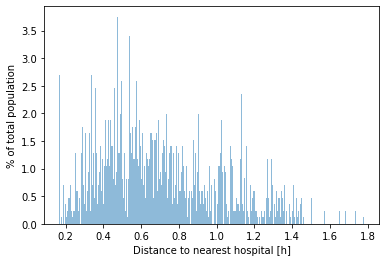

In [111]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
origins['t_'+usual_origin].plot.hist(alpha=0.5,bins=500,cumulative=False,density=True)
plt.ylabel('% of total population')
plt.xlabel('Distance to nearest '+usual_origin+' [h]')
plt.savefig('travel_time_dist.pdf')
plt.show()

In [ ]:
origins.to_file("data/origins.geojson", driver="GeoJSON")

origins.to_file("data/origins.shp", driver="ESRI Shapefile")

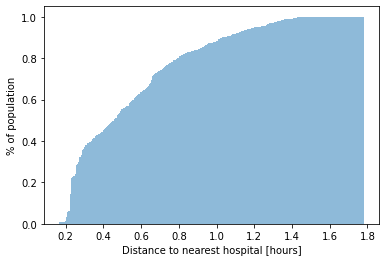

In [110]:
plt.figure()
origins['t_'+usual_origin].plot.hist(alpha=0.5,bins=500,cumulative=True,density=True,weights=origins['tot_pop'])
plt.ylabel('% of population')
plt.xlabel('Distance to nearest '+usual_origin+' [hours]')
plt.show()

In [108]:
for i in np.arange(10,101,10):
    print("El %i%% de la población en Asturias tarda %2.1f minutos en llegar al destino: %s"%
         (i,np.percentile(weight_array(origins['t_'+usual_origin].values*60, origins['tot_pop'].values), i),usual_origin))

NameError: name 'weight_array' is not defined

In [ ]:
lejos=origins[origins['t_'+usual_origin]>1].sort_values(by='t_'+usual_origin,ascending=False)

for index,lugar in lejos.head(n=5).iterrows():
    print("%i personas en %s tardan %2.1f horas en llegar al destino: %s"%
         (lugar["POBLACION"],lugar["NOMBRE"],lugar["t_"+usual_origin],usual_origin))
    get_route_link([hospitales.loc[lugar['m_hospital']]['lon'],hospitales.loc[lugar['m_hospital']]['lat']],
                   [lugar['lon'],lugar['lat']])


origins.to_file("data/origins.geojson", driver="GeoJSON")